## SemEval 2017 Task 4: Polarity Classification

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
import random
import torch

pd.set_option('max_colwidth', 200)

torch.manual_seed(2019)
np.random.seed(2019)
tf.random.set_random_seed(2019)
random.seed(2019)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def read_data(filename):
    df = pd.read_table(filename,
                         names=["id", "label", "text", "extra"], header=None, index_col="id",
                         quoting=csv.QUOTE_NONE)
    df.drop("extra", axis=1, inplace=True)
    
    return df



Cargamos datos

In [2]:
import os

train_filenames = [
     'twitter-2013dev-A.txt',
     'twitter-2013train-A.txt',
     'twitter-2014test-A.txt',
     'twitter-2014sarcasm-A.txt',
     'twitter-2015train-A.txt',
     'twitter-2015test-A.txt',
     'twitter-2016train-A.txt',
     'twitter-2016dev-A.txt',
     'twitter-2016test-A.txt',
     'twitter-2016devtest-A.txt',
]

train_dfs = []
for fn in train_filenames:
    fn = os.path.join("..", "..", "data", "other", "GOLD", "Subtask_A", fn)
    train_dfs.append(read_data(fn))
    
df_train = pd.concat(train_dfs)

df_train.drop(index='"', inplace=True)


df_test = read_data("../../data/other/SEMEVAL-2017/SemEval2017-task4-test.subtask-A.english.txt")
#df_test = read_data("../../data/other/GOLD/Subtask_A/twitter-2016test-A.txt")

# Tiro una línea basura

X_train, labels_train = df_train["text"], df_train["label"]
#X_dev, labels_dev = df_dev["text"], df_dev["label"]
X_test, labels_test = df_test["text"], df_test["label"]

In [3]:
df_test.iloc[:10]

,label,text
id,,
801989080477154944,neutral,#ArianaGrande Ari By Ariana Grande 80% Full https://t.co/ylhCMETHHW #Singer #Actress https://t.co/lTrb1JQiEA
801989272341453952,positive,Ariana Grande KIIS FM Yours Truly CD listening party in Burbank https://t.co/ClQIcx8Z6V #ArianaGrande
801990978424962944,positive,Ariana Grande White House Easter Egg Roll in Washington https://t.co/jdjL9swWM8 #ArianaGrande
801996232553963008,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4 oz 100 ML Sealed In Box 100% Authenic New https://t.co/oFmp0bOvZy… https://t.co/WIHLch9KtK
801998343442407040,neutral,SIDE TO SIDE 😘 @arianagrande #sidetoside #arianagrande #musically #comunidadgay #lgbt🌈 #LOTB… https://t.co/tEd8rftAxV
802001659970744064,positive,Hairspray Live! Previews at the Macy's Thanksgiving Day Parade! https://t.co/GaFTqInolL #arianagrande #televisionnbc
802003380973568000,positive,#LindsayLohan Is ‘Feeling Thankful’ After Blasting #ArianaGrande For Wearing ‘#TooMuch… https://t.co/Acf8ogvPxd https://t.co/EOSHtG9ay4
802014830467174016,neutral,I hate her but... I love her songs Dammit ._.#ArianaGrande
802020578609623040,neutral,Ariana Grande 【Right There ft. Big Sean】#アリアナ #arianagrande https://t.co/4rZOKYDnut


In [4]:
%%capture
from allennlp.commands.elmo import ElmoEmbedder
from elmoformanylangs import Embedder as ManyLangsEmbedder
import fastText
import os


fasttext_model = fastText.load_model(os.path.expanduser("../../WordVectors/wiki.en.bin"))


In [5]:
%%capture
import fastText
import os

class MyElmoAdapter:
    def __init__(self, embedder):
        self._embedder = embedder
        
    def sents2elmo(self, sents):
        #ret.append(np.array(self._elmo_embedder.sents2elmo(X_tokenized)))
        return np.array(list(self._embedder.embed_sentences(sents))).mean(axis=1)
    
# elmo_embedder = MyElmoAdapter(ElmoEmbedder(cuda_device=0))

elmo_embedder = ManyLangsEmbedder("../../models/elmo/en/")

In [6]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

y_train = label_encoder.fit_transform(labels_train.values)
y_test = label_encoder.transform(labels_test.values)

y_train = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = onehot_encoder.transform(y_test.reshape(-1, 1))

label_encoder.classes_

/home/jmperez/.pyenv/versions/3.6.5/envs/hateval/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array(['negative', 'neutral', 'positive'], dtype=object)

In [7]:
df_train['label'].value_counts()

neutral     21078
positive    18428
negative     7281
Name: label, dtype: int64

In [8]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=label_encoder.classes_, y=labels_train)

class_weights = {k:v for k, v in enumerate(class_weights)}

class_weights

{0: 2.14196767843245, 1: 0.7399025840528829, 2: 0.8463027277331597}

In [9]:
from hate.nn.preprocessing import Tokenizer
from hate.nn.base_model import BaseModel
import numpy as np
from keras.layers import (
    Input, Embedding, Dense, Dropout, Bidirectional, LSTM,
    GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D, CuDNNGRU, Concatenate, Softmax
)
import keras
from keras import regularizers
from elmoformanylangs import Embedder


class ElmoModel(BaseModel):
    def __init__(self, max_len, fasttext_model, elmo_embedder,
             tokenize_args={},
             recursive_class=CuDNNGRU, rnn_units=256, dropout=0.75, l1_regularization=0.00,
             pooling='max', bidirectional=False, **kwargs):


        self._max_len = max_len
        self._embedder = fasttext_model
        self._elmo_embedder = elmo_embedder
        self._elmo_dim = 1024
        # Build the graph

        inputs = []

        

        tok_args = {
            "preserve_case": False,
            "deaccent": False,
            "reduce_len": True,
            "strip_handles": True,
            "alpha_only": True,
            "stem": False
        }

        tok_args.update(tokenize_args)

        if self._elmo_embedder:
            elmo_input = Input(shape=(self._max_len, self._elmo_dim), name="Elmo")
            inputs.append(elmo_input)
        if self._embedder:
            embedding_size = fasttext_model.get_word_vector("pepe").shape[0]
            emb_input = Input(shape=(self._max_len, embedding_size), name="Fasttext")
            inputs.append(emb_input)

        if len(inputs) > 1:
            x = Concatenate()(inputs)
        else:
            x = inputs[0]

        recursive_args = {
            "return_sequences": True
        }

        if l1_regularization > .0:
            print("Using L1 regularization")
            recursive_args["kernel_regularizer"]= regularizers.l2(l1_regularization)

        rec_layer = recursive_class(
            rnn_units, **recursive_args)

        if bidirectional:
            rec_layer = Bidirectional(rec_layer)
        x = self.recursive_layer = rec_layer(x)


        if pooling == 'max':
            x = GlobalMaxPooling1D()(x)
        elif pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        else:
            raise ValueError("pooling should be 'max' or 'avg'")

        if dropout > 0:
            x = Dropout(dropout)(x)

        x = Dense(3, activation=None)(x)
        output = Softmax()(x)
        
        self.display_name = "{}{} with {} pooling consuming {}".format(
            'bi-' if bidirectional else '',
            type(recursive_class(50)).__name__,
            pooling,
            "+".join([i.name for i in inputs]),
        )
        super().__init__(
            inputs=inputs, outputs=[output],
            tokenize_args=tok_args, **kwargs
        )
        
    def preprocess_fit(self, X):
        return

    def _preprocess_tweet(self, tweet):
        tokens = self._tokenizer.tokenize(tweet)

        if len(tokens) >= self._max_len:
            tokens = tokens[:self._max_len]
        else:
            tokens = tokens + [''] * (self._max_len - len(tokens))
        return tokens

    def _get_embeddings(self, toks):
        return [self._embedder.get_word_vector(tok) for tok in toks]


    def preprocess_transform(self, X):
        X_tokenized = [self._preprocess_tweet(tweet) for tweet in X]

        ret = []

        if self._elmo_embedder:
            
            ret.append(np.array(self._elmo_embedder.sents2elmo(X_tokenized)))
        if self._embedder:
            fasttext_embeddings = np.array([
                self._get_embeddings(tweet) for tweet in X_tokenized
            ])
            ret.append(fasttext_embeddings)
        return ret


Using TensorFlow backend.


(array([  18.,  150.,  371.,  636.,  920., 1108., 1237., 1229., 1200.,
        1311., 1222., 1059.,  850.,  543.,  255.,  108.,   45.,   10.,
           9.,    3.]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25.,
        27., 29., 31., 33., 35., 37., 39., 41.]),
 <a list of 20 Patch objects>)

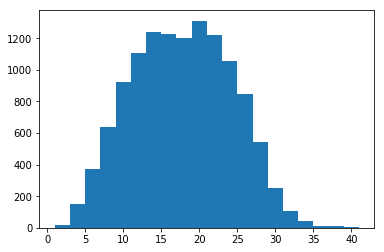

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

tokenizer = Tokenizer()

plt.hist([len(tokenizer.tokenize(tw)) for tw in X_test], bins=20)

In [11]:
from keras.optimizers import Adam
from keras.layers import LSTM, GRU, CuDNNLSTM, CuDNNGRU

max_length = 33


params = {
    "recursive_class": CuDNNGRU,
    "dropout": 0.45,
    "rnn_units": 1024, 
    "dropout": 0.5,
    "pooling": 'avg',
    "tokenize_args": {
        "preserve_case": False,
        "deaccent": False,
        "reduce_len": True,
        "strip_handles": True,
        "alpha_only": False,
        "stem": False
    }
}

optimizer_args = {
    "lr": 0.0007,
    "decay": 0.01,
}

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Elmo (InputLayer)               (None, 33, 1024)     0                                            
__________________________________________________________________________________________________
Fasttext (InputLayer)           (None, 33, 300)      0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 33, 1324)     0           Elmo[0][0]                       
                                                                 Fasttext[0][0]                   
__________________________________________________________________________________________________
cu_dnngru_1 (CuDNNGRU)          (None, 33, 1024)     7219200     concatenate_1[0][0]              
__________

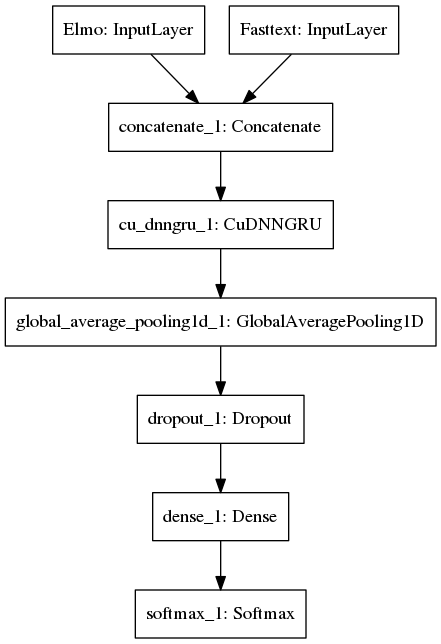

In [12]:

from keras.utils import plot_model
from IPython.display import Image


model = ElmoModel(
    max_length, fasttext_model=fasttext_model,
    elmo_embedder=elmo_embedder,
    **params
)

print(model.summary())




model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

plot_model(model, to_file='model.png')


Image(filename='model.png') 

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/gru_model_semeval_2016.h5', save_best_only=True, monitor='val_loss', verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=5)


model.fit(X_train, y_train, 
          callbacks=[checkpointer, early_stopper],
          validation_split=0.05,
          #validation_data=(X_dev, y_dev),
          class_weight=class_weights,
          epochs=100, verbose=1,
          batch_size=64)


Train on 44447 samples, validate on 2340 samples
Epoch 1/100
44447/44447 [==============================] - 21s 465us/step - loss: 0.5093 - acc: 0.7345 - val_loss: 0.5255 - val_acc: 0.7171

Epoch 00001: val_loss improved from inf to 0.52552, saving model to /tmp/gru_model_semeval_2016.h5
Epoch 2/100
44447/44447 [==============================] - 18s 406us/step - loss: 0.4549 - acc: 0.7674 - val_loss: 0.5153 - val_acc: 0.7308

Epoch 00002: val_loss improved from 0.52552 to 0.51534, saving model to /tmp/gru_model_semeval_2016.h5
Epoch 3/100
44447/44447 [==============================] - 17s 390us/step - loss: 0.4400 - acc: 0.7734 - val_loss: 0.5243 - val_acc: 0.7016

Epoch 00003: val_loss did not improve from 0.51534
Epoch 4/100
44447/44447 [==============================] - 17s 388us/step - loss: 0.4293 - acc: 0.7774 - val_loss: 0.5168 - val_acc: 0.7254

Epoch 00004: val_loss did not improve from 0.51534
Epoch 5/100
44447/44447 [==============================] - 17s 393us/step - loss: 0

## ELMo + fastText

In [14]:
from sklearn.metrics import accuracy_score


y_pred  = model.predict(X_test) >= 0.5

accuracy_score(y_test, y_pred)

0.5888147183327906

In [15]:
model_elmo_ft = model

## ELMo

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Elmo (InputLayer)            (None, 33, 1024)          0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 33, 1024)          6297600   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
_________________________________________________________________
softmax_2 (Softmax)          (None, 3)                 0         
Total params: 6,300,675
Trainable params: 6,300,675
Non-trainable params: 0
_________________________________________________________________


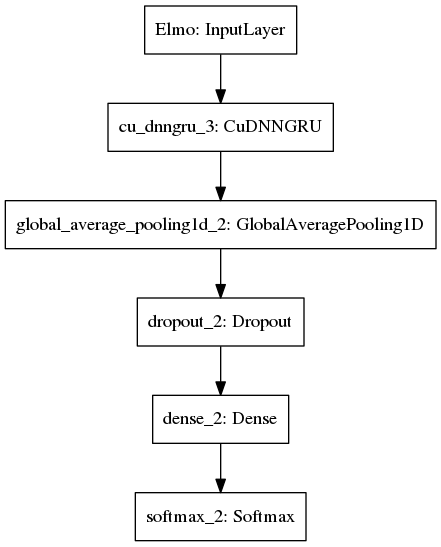

In [16]:
from keras.utils import plot_model
from IPython.display import Image


model = ElmoModel(
    max_length, fasttext_model=None,
    elmo_embedder=elmo_embedder,
    **params
)

print(model.summary())




model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

plot_model(model, to_file='model.png')


Image(filename='model.png') 

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/gru_model_semeval_2016.h5', save_best_only=True, monitor='val_loss', verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=5)


model.fit(X_train, y_train, 
          callbacks=[checkpointer, early_stopper],
          validation_split=0.05,
          class_weight=class_weights,
          epochs=100, verbose=1,
          batch_size=64)


Train on 44447 samples, validate on 2340 samples
Epoch 1/100
44447/44447 [==============================] - 17s 389us/step - loss: 0.5188 - acc: 0.7283 - val_loss: 0.5419 - val_acc: 0.7134

Epoch 00001: val_loss improved from inf to 0.54190, saving model to /tmp/gru_model_semeval_2016.h5
Epoch 2/100
44447/44447 [==============================] - 16s 359us/step - loss: 0.4747 - acc: 0.7551 - val_loss: 0.5387 - val_acc: 0.7093

Epoch 00002: val_loss improved from 0.54190 to 0.53871, saving model to /tmp/gru_model_semeval_2016.h5
Epoch 3/100
44447/44447 [==============================] - 16s 358us/step - loss: 0.4608 - acc: 0.7618 - val_loss: 0.5387 - val_acc: 0.7053

Epoch 00003: val_loss improved from 0.53871 to 0.53867, saving model to /tmp/gru_model_semeval_2016.h5
Epoch 4/100
44447/44447 [==============================] - 16s 358us/step - loss: 0.4521 - acc: 0.7663 - val_loss: 0.5352 - val_acc: 0.7140

Epoch 00004: val_loss improved from 0.53867 to 0.53516, saving model to /tmp/gru_m

In [18]:
from sklearn.metrics import accuracy_score

y_pred  = model.predict(X_test) >= 0.5

accuracy_score(y_test, y_pred)

0.5639042657114947

In [19]:
model_elmo = model

## fastText

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Fasttext (InputLayer)        (None, 33, 300)           0         
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 33, 1024)          4073472   
_________________________________________________________________
global_average_pooling1d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075      
_________________________________________________________________
softmax_3 (Softmax)          (None, 3)                 0         
Total params: 4,076,547
Trainable params: 4,076,547
Non-trainable params: 0
_________________________________________________________________


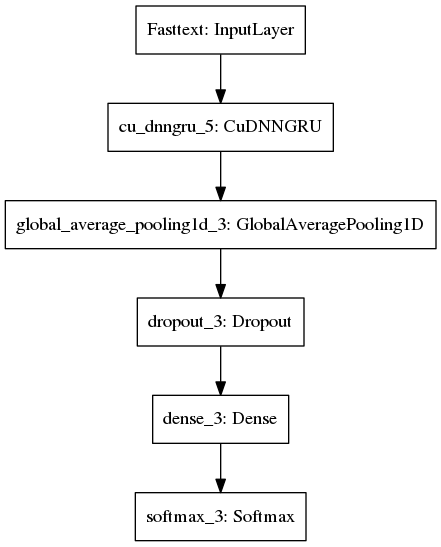

In [20]:
from keras.utils import plot_model
from IPython.display import Image


model = ElmoModel(
    max_length, fasttext_model=fasttext_model,
    elmo_embedder=None,
    **params
)

print(model.summary())




model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

plot_model(model, to_file='model.png')


Image(filename='model.png') 

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/gru_model_semeval_2016.h5', save_best_only=True, monitor='val_loss', verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=5)


model.fit(X_train, y_train, 
          callbacks=[checkpointer, early_stopper],
          validation_split=0.05, 
          class_weight=class_weights,
          epochs=100, verbose=1,
          batch_size=64)


Train on 44447 samples, validate on 2340 samples
Epoch 1/100
44447/44447 [==============================] - 12s 262us/step - loss: 0.5114 - acc: 0.7283 - val_loss: 0.5318 - val_acc: 0.7165

Epoch 00001: val_loss improved from inf to 0.53175, saving model to /tmp/gru_model_semeval_2016.h5
Epoch 2/100
44447/44447 [==============================] - 11s 240us/step - loss: 0.4677 - acc: 0.7570 - val_loss: 0.5251 - val_acc: 0.7113

Epoch 00002: val_loss improved from 0.53175 to 0.52512, saving model to /tmp/gru_model_semeval_2016.h5
Epoch 3/100
44447/44447 [==============================] - 11s 241us/step - loss: 0.4589 - acc: 0.7615 - val_loss: 0.5222 - val_acc: 0.7160

Epoch 00003: val_loss improved from 0.52512 to 0.52216, saving model to /tmp/gru_model_semeval_2016.h5
Epoch 4/100
44447/44447 [==============================] - 11s 238us/step - loss: 0.4525 - acc: 0.7647 - val_loss: 0.5226 - val_acc: 0.7178

Epoch 00004: val_loss did not improve from 0.52216
Epoch 5/100
44447/44447 [======

In [22]:
y_pred  = model.predict(X_test) >= 0.5

accuracy_score(y_test, y_pred)

0.5394822533376751

In [23]:
model_ft = model